In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# PatchCamelyon Benchmark

This [repository](https://github.com/larsleijten/pcam "larsleijten/pcam") was built as a small demonstration of several deep learning solutions for the PatchCamelyon (PCAM) dataset. This dataset was selected due to its limited image size, which allows the use of  Google Colab GPUs for training of several models. 

# Data

All models are trained, validated and tested on the [PatchCamelyon](https://github.com/basveeling/pcam) dataset. The dataset contains 327,680 RGB histopatholical scan images of 96x96 pixels. The images where binary labelled on the presense of metastatic tissue. 

The dataset was split in a training set of 262,144 images and a validation and test set both consisting of 32,768 images. 

A dataloader with a batch size of 128 was used, with shuffled images for the training set. The training set was augmented by applying random rotation, horizontal flips and vertical flips, as baseline augmentations. These augmentations should be realistic types of deformations in pathology slides without disturbing the original image.

# Models

Four different approaches where applied on the learning problem to test their initial effectiveness and behaviour. 

**ConvNet**

A small, self-implemented ConvNet was used as a baseline. It consisted of three blocks of two convolutional layers with a max pooling layer, followed by two fully connected layers. The model can be found in ConvNet.py

**Finetuned Resnet50**

A Resnet50 pretrained on ImageNet (1K, Version 2) had its fully connected layers adapted to fit our classification problem. All layers except the fully connected layers where frozen, so the model could be finetuned on the pretrained "features".

**Pretrained Resnet50**

An identical pretrained Resnet50 was completely retrained on the PCAM dataset. 

**Randomly Initialized Resnet50**

The final solution was a Resnet50 with randomly initialized values for its parameters.  

# Training

Training of all models was performed for 15 epochs over the entire train dataset. An Adam optimizer was used with an initial learning rate of 10<sup>-3</sup> with weight decay of 10<sup>-5</sup>. The learning rate was decreased after epoch 5 (learning rate = 10<sup>-4</sup>, weight decay = 10<sup>-5</sup>) and both were decreased after epoch 10 (learning rate = 10<sup>-5</sup>, weight decay = 10<sup>-6</sup>). 

# Baseline results

The results are shown by running the code cells below. In the first cell, the resulting loss is plotted against the number of trained epochs over the training set. The second cell plots the accuracy against the number of trained epochs.

The small ConvNet suffered from instability during training, which might be explained by an exploding gradients problem. When plotting a selection of parameters and gradients to investigate the problem, it could indeed be observed that the gradients became very large, with rapidly varying model parameters as a result. Its optimal performance occured after training for two epochs, with an accuracy on the validation set of 78.6%.

The finetuned ResNet did not suffer from instability during training, as can be seen by the steadily declining training loss. Using a model pretrained on the ImageNet dataset did not prove to be an effective feature extractor, since the best performing model only reached a validation accuracy of 73.6% after training for 10 epochs. 

Retraining a pretrained ResNet produced better results, with a validation accuracy of 87.0% after training for only one epoch. After training for 15 epochs, the training accuracy reached 97.9%.

Training the ResNet from scratch performed slightly worse than retraining the pretrained ResNet.  An optimal validation accuracy of 83.2% was reached after 8 epochs of training. Training accuracy reached 96.7% after 15 epochs. 

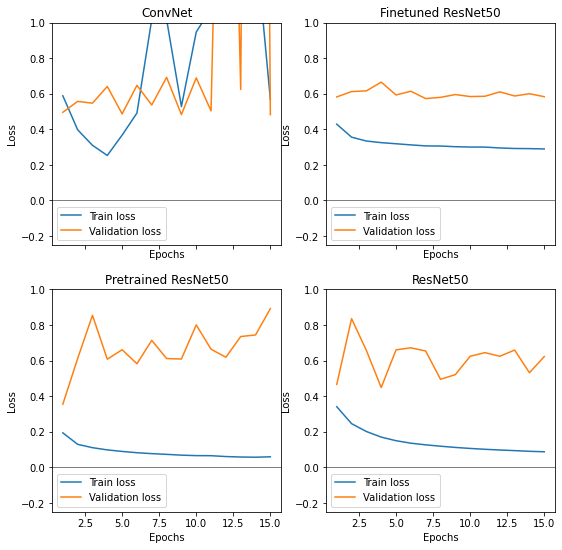

In [23]:
train_loss = pd.read_csv("https://raw.githubusercontent.com/larsleijten/pcam/main/results/baseline_train_loss.csv")
train_accuracy = pd.read_csv("https://raw.githubusercontent.com/larsleijten/pcam/main/results/baseline_train_accuracy.csv")
validation_loss = pd.read_csv("https://raw.githubusercontent.com/larsleijten/pcam/main/results/baseline_validation_loss.csv")
validation_accuracy = pd.read_csv("https://raw.githubusercontent.com/larsleijten/pcam/main/results/baseline_validation_accuracy.csv")

# Plot the loss
fig, axes2d = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(9,9))

for idx, title, ax in zip(['convnet', 'ft_resnet', 'pt_resnet', 'resnet'], ['ConvNet', 'Finetuned ResNet50', 'Pretrained ResNet50', 'ResNet50'], np.ravel(axes2d)):
  ax.plot(range(1,16), train_loss[idx], label="Train loss")
  ax.plot(range(1,16), validation_loss[idx], label="Validation loss")
  ax.set_ylim([-0.25,1])
  ax.legend(loc="lower left")
  ax.set_title(title)
  ax.set_xlabel("Epochs")
  ax.set_ylabel("Loss")
  ax.axhline(y=0, color='k', linewidth=0.5)

plt.show()

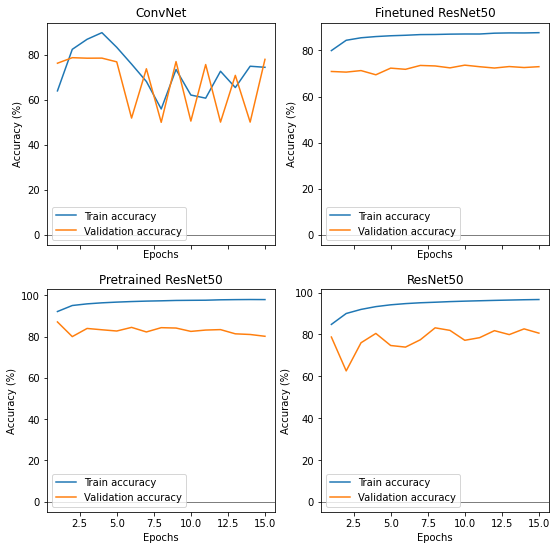

In [24]:
# Plot the accuracy
fig, axes2d = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(9,9))

for idx, title, ax in zip(['convnet', 'ft_resnet', 'pt_resnet', 'resnet'], ['ConvNet', 'Finetuned ResNet50', 'Pretrained ResNet50', 'ResNet50'], np.ravel(axes2d)):
  ax.plot(range(1,16), train_accuracy[idx], label="Train accuracy")
  ax.plot(range(1,16), validation_accuracy[idx], label="Validation accuracy")
  ax.legend(loc="lower left")
  ax.set_title(title)
  ax.set_xlabel("Epochs")
  ax.set_ylabel("Accuracy (%)")
  ax.axhline(y=0, color='k', linewidth=0.5)

plt.show()

# Overfitting

In all three ResNet50 implementations, a relevant degree of overfitting could be observed, characterized by the difference between the training loss and the validation loss. While the training loss and accuracy keep improving steadily, both the validation loss and accuracy plateau quickly. The pretrained ResNet50 even reached its optimum validation accuracy after training for only one epoch. 

The models likely recognize some patterns in the training data, which 
are not related to the presence of a metastasis. Methods such as data augmentation and regularization could help to prevent overfitting. 

# Improvements

After observing the baseline results, it was decided to optimize the training of the pretrained ResNet50. This model reached the best performance after little training. Several additional regularization and data-augmentation methods were implemented until the overfitting was observed to decrease significantly. 

The additional data augmentation methods consisted of:
*   Dropout layers in the fully connected layers
*   Random cropping
*   Random Inverting of the image
*   Random contrast, brightness and hue adaptations
*   Random grayscale conversions

The results of this optimized training are shown by running the code cell below. After training for 30 epochs, the training accuracy reached 91.4%.Validation accuracy reached 90.3% after training for 30 epochs, an improvement of 3.3 percent point.

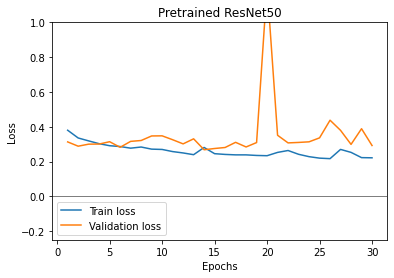

In [25]:
optim_train_loss = pd.read_csv("https://raw.githubusercontent.com/larsleijten/pcam/main/results/optimized_train_loss.csv")
optim_train_accuracy = pd.read_csv("https://raw.githubusercontent.com/larsleijten/pcam/main/results/optimized_train_accuracy.csv")
optim_validation_loss = pd.read_csv("https://raw.githubusercontent.com/larsleijten/pcam/main/results/optimized_validation_loss.csv")
optim_validation_accuracy = pd.read_csv("https://raw.githubusercontent.com/larsleijten/pcam/main/results/optimized_validation_accuracy.csv")

# Plot the loss
plt.plot(range(1,31), optim_train_loss['pt_resnet'], label="Train loss")
plt.plot(range(1,31), optim_validation_loss['pt_resnet'], label="Validation loss")
plt.ylim([-0.25,1])
plt.legend(loc="lower left")
plt.title("Pretrained ResNet50")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.axhline(y=0, color='k', linewidth=0.5)

plt.show()

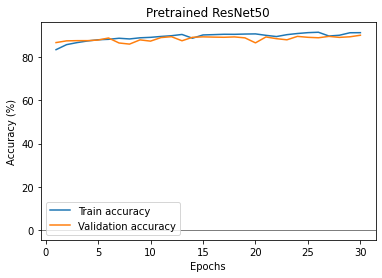

In [26]:
# Plot the accuracy
plt.plot(range(1,31), optim_train_accuracy['pt_resnet'], label="Train accuracy")
plt.plot(range(1,31), optim_validation_accuracy['pt_resnet'], label="Validation accuracy")
plt.ylim([-5,100])
plt.legend(loc="lower left")
plt.title("Pretrained ResNet50")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.axhline(y=0, color='k', linewidth=0.5)

plt.show()

# Test Time Augmentation (TTA)

Test Time Augmentation (TTA) was used to further improve model performance. In this approach, inference was performed on the original image, but also on flipped of the same image. The average outcome of the model prediction on these images was taken as the overall model prediction. This method improved validation accuracy slightly from 90.3% to 90.5%. The Area Under the Receiver Operator Characteristic (AUROC) was 0.9644. 

# Inference on the test set

Using TTA, model performance was evaluated on the previously unseen (and untouched) test set of 32,768 images. The test accuracy was 89.1% with an AUROC of 0.9668.





# Conclusions
The developed algorithm reached an AUROC of 0.9668 (0.9660 at submission), which corresponds to a 11<sup>th</sup> place out of 174 submissions on the leaderbord of the PatchCamelyon challenge. The use of data augmentation and regularization was able to prevent overfitting. This resulted in a relatively high accuracy of the trained ResNet50 in classifying cancer in medical pathology slides. 